In [98]:
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm
from time import time

import pyconll
from scripts.TreeKernel import tree, tree_kernels

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline


In [2]:

def to_prolog(tree: pyconll.tree.tree.Tree) -> str:
    if tree._children:
        children_repr = ', '.join(to_prolog(child) for child in tree._children)
        return f'_({children_repr})'
    else:
        return f'_'

"""
def calc_kernel_matrix(data1, data2, kernel: tree_kernels.KernelST):
    n1, n2 = len(data1), len(data2)
    matrix = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            matrix[i][j] = kernel.kernel(data1[i], data2[j])
    return matrix
"""


'\ndef calc_kernel_matrix(data1, data2, kernel: tree_kernels.KernelST):\n    n1, n2 = len(data1), len(data2)\n    matrix = np.zeros((n1, n2))\n    for i in range(n1):\n        for j in range(n2):\n            matrix[i][j] = kernel.kernel(data1[i], data2[j])\n    return matrix\n'

In [3]:
random_state = 50

In [ ]:
CoNLL = pyconll.load_from_file("corpora/English/English-EWT.conllu")
count_en = len(CoNLL)
CoNLL += pyconll.load_from_file("corpora/English/English-Atis.conllu")
count_ja = len(CoNLL) - count_en

labels = [0]*count_en + [1]*count_ja

trees = [conll.to_tree() for conll in CoNLL]

data = []

for t in trees:
    root = tree.TreeNode.fromPrologString(to_prolog(t))
    tree_ = tree.Tree(root)
    data.append(tree_)


In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.20, random_state=random_state
)

    # 部分木の比較用カーネルを作成
lambda_value = 0.5
kernel = tree_kernels.KernelST(lambda_value)


In [ ]:
train_kernel_matrix = calc_kernel_matrix(train_data[:100], train_data[:100], kernel)

In [ ]:
train_kernel_matrix

In [ ]:
matrix_T = train_kernel_matrix.copy().transpose()

In [ ]:
matrix_T

In [ ]:
np.equal(train_kernel_matrix, matrix_T)

In [ ]:
np.array_equal(train_kernel_matrix, matrix_T)

In [ ]:
n = 5
matrix = np.zeros((n,n))
for i in range(n):
    for j in range(i,n):
        matrix[i,j] = kernel.kernel(train_data[i], train_data[j])

In [ ]:
matrix

In [ ]:
matrix + matrix.T - np.diag(matrix.diagonal())

### 単一言語間の差異(English-EWT, ESL, Atis)

In [65]:
CoNLL_EN = pyconll.load_from_file("corpora/English/English-EWT.conllu")

num_EWT = len(CoNLL_EN)

CoNLL_EN += pyconll.load_from_file("corpora/English/English-ESL.conllu")

num_ESL = len(CoNLL_EN) - num_EWT

CoNLL_EN += pyconll.load_from_file("corpora/English/English-Atis.conllu")

num_Atis = len(CoNLL_EN) - num_ESL - num_EWT


labels = [0]*num_EWT + [1]*num_ESL + [2]*num_Atis

trees = [conll.to_tree() for conll in CoNLL_EN]

data = []

for t in trees:
    root = tree.TreeNode.fromPrologString(to_prolog(t))
    tree_ = tree.Tree(root)
    data.append(tree_)

In [66]:
lambda_value = 0.5
kernel = tree_kernels.KernelST(lambda_value)

In [67]:
def calc_kernel_matrix(kernel: tree_kernels.Kernel, data1, data2=None):
    
    if data2==None:
        n = len(data1)
        matrix = np.zeros((n,n))
        for i in tqdm(range(n)):
            for j in range(i,n):
                matrix[i][j] = kernel.kernel(data1[i], data1[j])
        return matrix + matrix.T -np.diag(matrix.diagonal())

    n1, n2 = len(data1), len(data2)
    matrix = np.zeros((n1, n2))
    for i in tqdm(range(n1)):
        for j in range(n2):
            matrix[i][j] = kernel.kernel(data1[i], data2[j])
    return matrix

In [68]:
kernel_mat = calc_kernel_matrix(kernel=kernel, data1=data)

  0%|          | 0/27177 [00:00<?, ?it/s]

In [69]:
kernel_matrix_between_ENs = kernel_mat

In [64]:
%store kernel_matrix_between_ENs

Stored 'kernel_matrix_between_ENs' (ndarray)


/home/yamazoe/.pyenv/versions/3.11.7/envs/env_pq/lib/python3.11/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/kernel_matrix_between_ENs requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


In [70]:
np.save("kernel_matrix_between_En_corpora", kernel_matrix_between_ENs)

In [71]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(kernel_matrix_between_ENs)

In [118]:
axes_ticks= [-150, -100, -50, 0, 50, 100, 150]
axes_labels = ["", -100, "", 0, "", 100, ""]

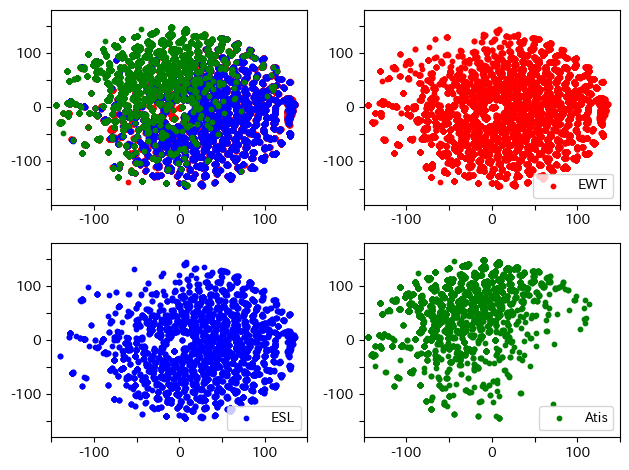

In [127]:
fig, ax = plt.subplots(2,2, tight_layout=True)

ax[0,0].scatter(X_reduced[:num_EWT,0], X_reduced[:num_EWT,1], label="EWT", alpha=1, s=10, c="r")
ax[0,0].scatter(X_reduced[num_EWT:num_EWT+num_ESL,0], X_reduced[num_EWT:num_EWT+num_ESL,1], label="ESL", alpha=1, s=10, c="b")
ax[0,0].scatter(X_reduced[num_EWT+num_ESL:,0], X_reduced[num_EWT+num_ESL:,1],label="Atis", alpha=1, s=10, c="g")

ax[0,0].set_xlim(-150, 150)
ax[0,0].set_ylim(-180, 180)

ax[0,0].set_xticks(axes_ticks)
ax[0,0].set_xticklabels(axes_labels)
ax[0,0].set_yticks(axes_ticks)
ax[0,0].set_yticklabels(axes_labels)


ax[0,1].scatter(X_reduced[:num_EWT,0], X_reduced[:num_EWT,1], label="EWT", alpha=1, s=10, c="r")

ax[0,1].set_xlim(-150, 150)
ax[0,1].set_ylim(-180, 180)

ax[0,1].set_xticks(axes_ticks)
ax[0,1].set_xticklabels(axes_labels)
ax[0,1].set_yticks(axes_ticks)
ax[0,1].set_yticklabels(axes_labels)

ax[0,1].legend(loc="lower right")

ax[1,0].scatter(X_reduced[num_EWT:num_EWT+num_ESL,0], X_reduced[num_EWT:num_EWT+num_ESL,1], label="ESL", alpha=1, s=10, c="b")

ax[1,0].set_xlim(-150, 150)
ax[1,0].set_ylim(-180, 180)

ax[1,0].set_xticks(axes_ticks)
ax[1,0].set_xticklabels(axes_labels)
ax[1,0].set_yticks(axes_ticks)
ax[1,0].set_yticklabels(axes_labels)

ax[1,0].legend(loc="lower right")

ax[1,1].scatter(X_reduced[num_EWT+num_ESL:,0], X_reduced[num_EWT+num_ESL:,1],label="Atis", alpha=1, s=10, c="g")

ax[1,1].set_xlim(-150, 150)
ax[1,1].set_ylim(-180, 180)

ax[1,1].set_xticks(axes_ticks)
ax[1,1].set_xticklabels(axes_labels)
ax[1,1].set_yticks(axes_ticks)
ax[1,1].set_yticklabels(axes_labels)

ax[1,1].legend(loc="lower right")


plt.savefig("tmp.png", dpi=600)

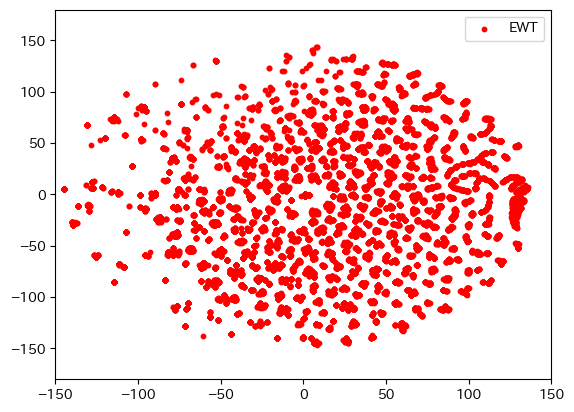

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_reduced[:num_EWT,0], X_reduced[:num_EWT,1], label="EWT", alpha=1, s=10, c="r")

ax.set_xlim(-150, 150)
ax.set_ylim(-180, 180)

ax.legend()

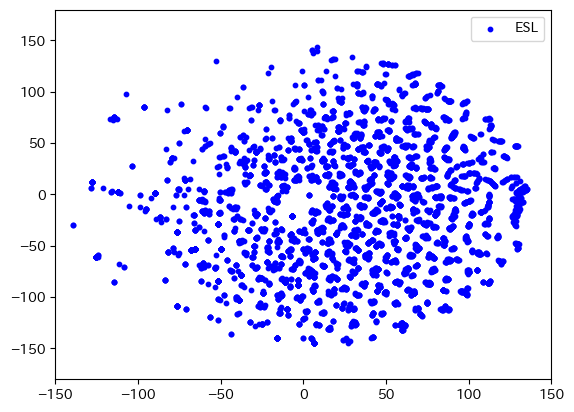

In [ ]:
fig, ax = plt.subplots()
ax[1,1].scatter(X_reduced[num_EWT:num_EWT+num_ESL,0], X_reduced[num_EWT:num_EWT+num_ESL,1], label="ESL", alpha=1, s=10, c="b")

ax[1,1].set_xlim(-150, 150)
ax[1,1].set_ylim(-180, 180)

ax[1,1].legend()

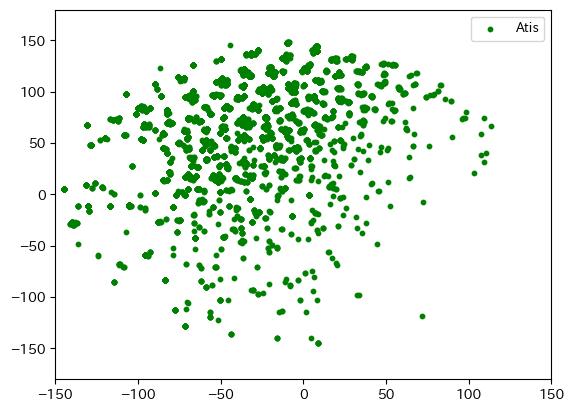

In [ ]:
fig, ax = plt.subplots()
ax[1,1].scatter(X_reduced[num_EWT+num_ESL:,0], X_reduced[num_EWT+num_ESL:,1],label="Atis", alpha=1, s=10, c="g")

ax[1,1].set_xlim(-150, 150)
ax[1,1].set_ylim(-180, 180)

ax[1,1].legend()

### 複数言語間の比較

English-EWT, Japanese-BCCWJ, French-GSD, Chinese-GSD, Korean-Kaist

In [ ]:
nums_list = []

CoNLL_multi = pyconll.load_from_file("corpora/English/English-EWT.conllu")
num_En = len(CoNLL_multi)
nums_list.append(num_En)

CoNLL_multi += pyconll.load_from_file("corpora/Japanese/Japanese-BCCWJ.conllu")
num_Ja = len(CoNLL_multi) - sum(nums_list)
nums_list.append(num_En)

CoNLL_multi += pyconll.load_from_file("corpora/French/French-GSD.conllu")
num_Fr = len(CoNLL_multi) - sum(nums_list)
nums_list.append(num_Fr)

CoNLL_multi += pyconll.load_from_file("corpora/Chinese/Chinese-GSD.conllu")
num_Zh = len(CoNLL_multi) - sum(nums_list)
nums_list.append(num_Zh)

CoNLL_multi += pyconll.load_from_file("corpora/Korean/Korean-Kaist.conllu")
num_Ko = len(CoNLL_multi) - sum(nums_list)
nums_list.append(num_Ko)




labels = []
for i, nums in enumerate(nums_list):
    labels += [i]*nums


trees = [conll.to_tree() for conll in CoNLL_multi]

data = []

for t in trees:
    root = tree.TreeNode.fromPrologString(to_prolog(t))
    tree_ = tree.Tree(root)
    data.append(tree_)

print(len(data))

In [129]:
lambda_value = 0.5
kernel = tree_kernels.KernelST(lambda_value)

In [ ]:
kernel_matrix_multi = calc_kernel_matrix(kernel=kernel, data1=data)
np.save("kernel_matrix_multi_languages", kernel_matrix_multi)

  0%|          | 0/115187 [00:00<?, ?it/s]